In [44]:
import pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
import pandas as pd 

###!!!
# RENAME ss => spark as done in faq.py
###!!!
ss = SparkSession.builder \
                .master("local") \
                .appName("311 Analysis") \
                .getOrCreate()

In [21]:
cdf = ss.read.csv('data/311_small.csv', header=True)
# 1. Filter for only rows where we have a HEATING complaint
hdf = cdf.filter(cdf["Complaint Type"].like('%HEATING%'))

In [22]:
# 2. Clean the address data
def clean_address(address):
    try:
        return str.upper(address).strip()
    except:
        return None
    
clean_address_as_col = F.udf(lambda address: address.upper().strip() if address else None, StringType())

hdf = hdf.withColumn('Address', 
                     clean_address_as_col('Incident Address'))

In [23]:
# 3. Use Wikipedia data to find 311 borough
# Ideally, instead of using this loaded dict, would use some kind of RDD...
def import_neighborhoods(fname):
    '''
    import wikipedia neighborhoods file
    returns: dictionary where key is borough
        and value is list of neighborhoods
    '''
    with open(fname,'r') as f:
        raw = f.read()
    lines = raw.split('\n')
    boroughs = {}
    for line in lines:
        fields = line.split(',')
        borough = fields.pop(0)
        if borough not in boroughs:
            boroughs[borough]=[]
        for f in fields:
            if f:
                neighborhood = str.upper(f.strip())
                boroughs[borough].append(neighborhood)
    boroughs2 = {'QN':boroughs['Queens']+['QUEENS'],
                 'BK':boroughs['Brooklyn']+['BROOKLYN'],
                 'MN':boroughs['Manhattan']+['MANHATTAN','NEW YORK'],
                 'SI':boroughs['Staten Island']+['STATEN ISLAND'],
                 'BX':boroughs['Bronx']+['BRONX']}
    return boroughs2

def city2borough(city):
    for borough,hood_list in neighborhoods.iteritems():
        if city in hood_list:
            return borough

#import neighborhoods data
hoods_fname='data/wiki_neighborhoods_2.csv'
##
neighborhoods = import_neighborhoods(hoods_fname)

In [24]:
city2borough_col = F.udf(city2borough)
hdf = hdf.withColumn('Borough', city2borough_col('City'))

In [25]:
bdf = ss.read.csv('Buildings_Clean.csv', header=True)
bdf.head()

Row(_c0=u'28880', Address=u'172 GELDNER AVENUE', XCoord=None, YCoord=None, ZipCode=u'10306.0', YearBuilt=u'2016', Borough=u'SI')

In [26]:
mdf = hdf.join(bdf, on=['Address','Borough'], how='inner')

In [50]:
totals = bdf.groupby(['YearBuilt']).agg({'*':'count'})
totals = totals.withColumnRenamed('count(1)', 'total')

complaints = mdf.groupby(['YearBuilt','Complaint Type']).agg({'*':'count'})
complaints = complaints.withColumnRenamed('count(1)','complaints')

result = totals.join(complaints, on='YearBuilt', how='inner')
# Write to CSV
result.toPandas().to_csv('result.csv')

In [51]:
df = pd.read_csv('result.csv').sort_values('YearBuilt')

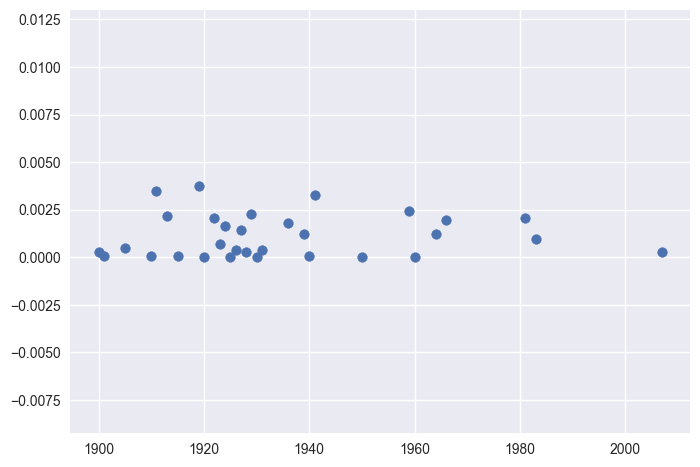

In [60]:
%matplotlib inline
plt.scatter(df['YearBuilt'], (df['complaints']/df['total']))